In [74]:
import numpy as np
import pandas as pd 
import geopandas as gpd 
import shapely 
from shapely.geometry import box, Polygon
from shapely.validation import make_valid 
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [20]:
gdf_predefined = gpd.read_file(
    'ground_truths/predefined_polygons.gpkg'
)

gdf_generated = gpd.read_file(
    'validation/patch_1_delineation.gpkg'
)

In [92]:
def modify_polygons(
        gdf: gpd.GeoDataFrame,
        type: str, 
        min_polygon_area: float=0.5,
        max_polygon_area: float=500.0,
        elongation_thresh: float=100.0
) -> gpd.GeoDataFrame:
    '''
    This function modifies the predefined and generated polygon gdf, by first
    attaching relevant geometric quantities (centroid and areas) to each polygon.
    Additionally, if the gdf is that of the generated polygons, it filters the
    data to remove very small and large polygons along with elongated shapes.

    Args: (i) gdf - the geopandas dataframe
          (ii) type - specifies the type of dataframe, either 'Predefined' or 'Generated'
          (iii) min_polygon_area - the minimum area of polygons required in gdf_generated; defaults to 0.5 acres
          (iv) max_polygon_area - the maximum area of polygons required in gdf_generated; defaults to 200 acres
          (v) elongation_thresh - threshold for elongation parameter; defaults to 150
    '''
    
    # Calculate relevant geometry quantities
    gdf['centroid'] = gdf.geometry.centroid 
    geom_pseudo_mercator = gdf.geometry.to_crs('EPSG:3587')
    gdf['area (sq. meters)'] = geom_pseudo_mercator.area 
    gdf['area (acres)'] = geom_pseudo_mercator.area * 0.000247 

    if type == 'Predefined':
        return gdf 
    
    elif type == 'Generated':
        '''
        Even after filtering, there will be polygons which are elongated in nature (rivers, streets etc.).
        From common experience, crop fields generally have quite regular shapes. One metric that can be used
        is an elongation ration calculated as perimeter^2 / area. As a reference, such a ratio for a square is
        16. We can set a custom cut-off to further filter out polygons which are very elongated and, hence, not
        representative of fields.
        '''
        elongation = (geom_pseudo_mercator.length**2) / gdf['area (sq. meters)']
        gdf['elongation'] = elongation 

        gdf_filtered = gdf[
            (gdf['area (acres)'] >= min_polygon_area) &
            (gdf['area (acres)'] <= max_polygon_area) &
            (gdf['elongation'] <= elongation_thresh)
        ]

        return gdf_filtered.reset_index(drop=True)
    
    else:
        raise ValueError('Invalid argument for type')
    
def polygon_overlaps(gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    '''
    This function calculates the overlapping regions between the predefined polygons and
    the ones generated using SamGeo.

    Args: (i) gdf1 - a geopandas dataframe containing the predefined polygons
          (ii) gdf2 - a geopandas dataframe containing the generated polygons

    Returns: a geopandas dataframe containing the overlapping regions sorted by IoU

    The returned geopandas dataframe contains `left_index` and `right_index` indicating
    which polygons in the two original dataframes were overlapped. It also contains an
    extra geometry column (geom_right) for the purposes of IoU calculation.
    '''

    def IoU(poly1: shapely.Polygon, poly2: shapely.Polygon) -> float:
        ''' 
        This is a simple function that calculates the `intersection-over-area` metric for
        determining the extent of overlap between predefined and generated polygons. The
        function is defined to be applied to geopandas dataframe rows using the apply() method.

        Args: (i) poly1 - the left polygon geometry
              (ii) poly2 - the right polygon geometry
        
        Returns: the IoU value
        '''
        intersection = poly1.intersection(poly2).area 
        union = poly1.union(poly2).area 
        iou = intersection / union 

        return iou

    # Checking if the two dataframes have similarly sized bounding boxes 
    # Rounding up their lon/lat to three decimal places
    gdf1_bounds = np.round(gdf1.total_bounds, decimals=3)
    gdf2_bounds = np.round(gdf2.total_bounds, decimals=3)

    if (gdf1_bounds != gdf2_bounds).any(): 
        xmin, ymin, xmax, ymax = gdf2_bounds 

        gdf1 = gdf1.cx[xmin:xmax, ymin:ymax] # coordinate-based slicing

    '''
    To get a sense of how many of the generated mask polygons intersect with the predefined ones,
    we perform a `spatial join` with an `intersects` predicate. This will return a dataframe containing
    information on which mask polygons intersect with which predefined polygons.
    '''

    gdf_joined = gpd.sjoin(
        left_df=gdf1,
        right_df=gdf2,
        predicate='intersects',
        how='inner'
    )

    gdf_joined['index_right'] = gdf_joined['index_right'].astype('Int32') # the right_df index may get converted to float
    gdf_joined = (
        gdf_joined
        .reset_index()
        .rename(columns={'index': 'index_left'})
    )

    # Attach the generated polygon geometry as a `geom_right` colums for further calculations
    geom_right = gdf2.loc[gdf_joined['index_right']].geometry.reset_index(drop=True)
    gdf_joined.insert(6, 'geom_right', geom_right)

    gdf_joined.drop(columns=['elongation'], inplace=True)

    # Check for invalid geometries in the predefined dataframe
    geom_check = shapely.is_valid(gdf_joined.geometry)
    invalid_geom_idx = geom_check[~geom_check].index

    for idx in invalid_geom_idx:
        gdf_joined.loc[idx, 'geometry'] = make_valid(gdf_joined.loc[idx, 'geometry'])
    
    gdf_joined['IoU'] = gdf_joined.apply(
        lambda row: IoU(row['geometry'], row['geom_right']),
        axis=1
    )

    '''
    There will be instances where a predefined polygon has intersections with multiple
    mask polygons. We group the data such that we keep only intersections with highest
    IoU and arrange it in descending order of IoU
    '''

    idx = (
        gdf_joined
        .groupby('index_left')['IoU']
        .idxmax()
    )

    gdf_joined = (
        gdf_joined
        .loc[idx]
        .sort_values(by='IoU', ascending=False)
        .reset_index(drop=True)
    )

    return gdf_joined

In [44]:
gdf_predefined = modify_polygons(gdf_predefined, 'Predefined')
gdf_generated = modify_polygons(gdf_generated, 'Generated')

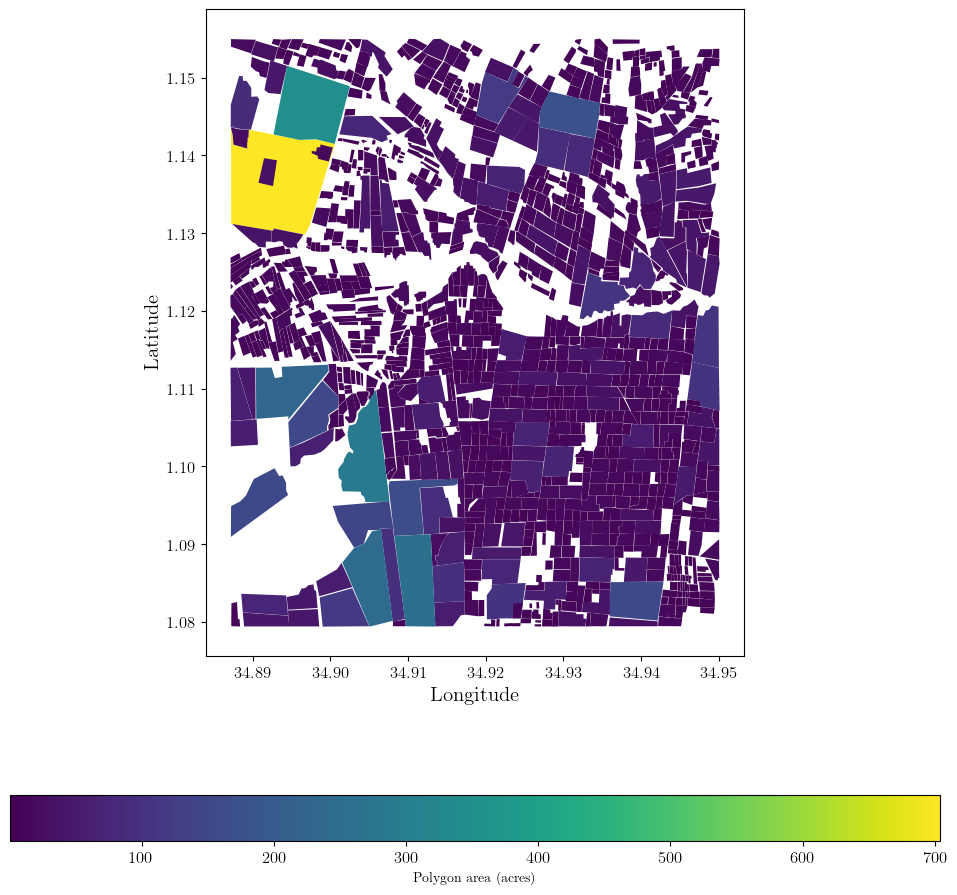

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_predefined.plot(
    ax=ax,
    column='area (acres)',
    cmap='viridis',
    legend=True,
    legend_kwds={"label": "Polygon area (acres)", "orientation": "horizontal"}
)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.show()

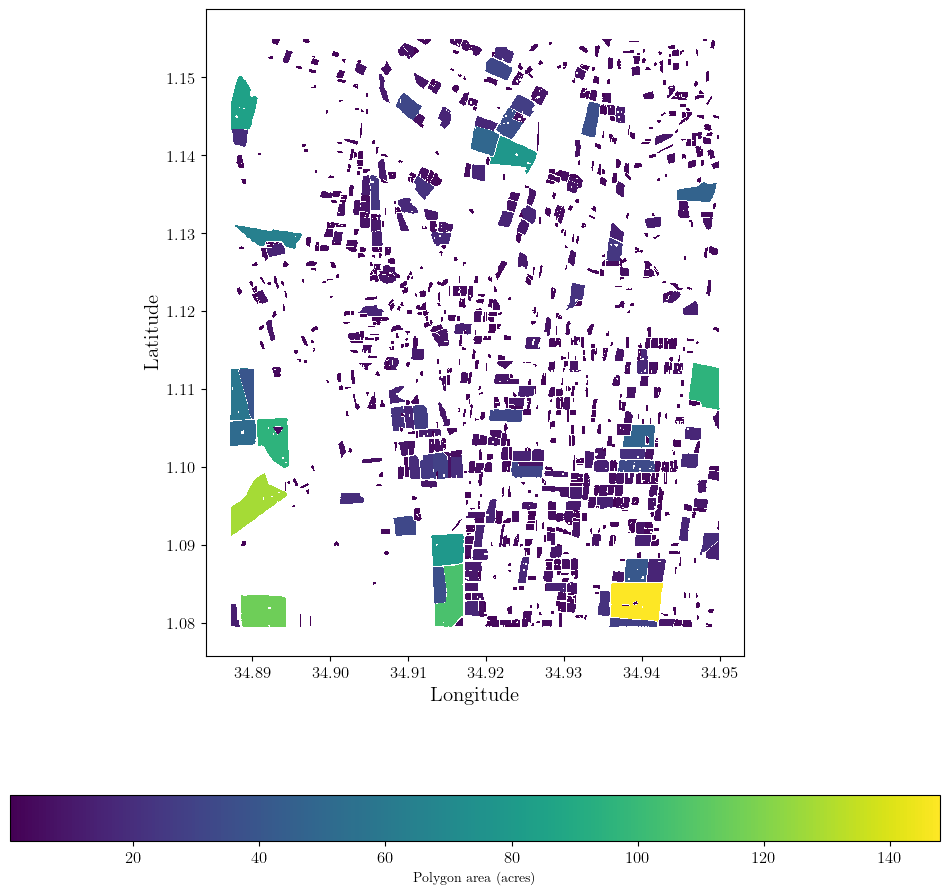

In [45]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_generated.plot(
    ax=ax,
    column='area (acres)',
    cmap='viridis',
    legend=True,
    legend_kwds={"label": "Polygon area (acres)", "orientation": "horizontal"}
)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.show()

In [93]:
gdf_overlap = polygon_overlaps(gdf_predefined, gdf_generated)

gdf_overlap.head()

,index_left,geometry,centroid_left,area (sq. meters)_left,area (acres)_left,index_right,geom_right,value,centroid_right,area (sq. meters)_right,area (acres)_right,IoU
0,758,"POLYGON ((34.93602 1.0851, 34.94287 1.08512, 3...",POINT (34.93931 1.0828),636010.665555,157.094634,1067,"POLYGON ((34.93626 1.08514, 34.93626 1.0851, 3...",255.0,POINT (34.93931 1.08284),598668.239882,147.871055,0.938977
1,467,"POLYGON ((34.94657 1.11342, 34.94594 1.10863, ...",POINT (34.9482 1.11033),415483.507008,102.624426,697,"POLYGON ((34.94664 1.11331, 34.94664 1.11327, ...",255.0,POINT (34.94816 1.11038),386616.186061,95.494198,0.930332
2,2,"POLYGON ((34.88719 1.14655, 34.88826 1.15022, ...",POINT (34.88879 1.14633),355953.147624,87.920427,141,"POLYGON ((34.88847 1.15019, 34.88847 1.15015, ...",255.0,POINT (34.88877 1.1463),342455.163016,84.586425,0.925986
3,566,"POLYGON ((34.94519 1.10185, 34.94736 1.10161, ...",POINT (34.94615 1.10083),81735.723799,20.188724,798,"POLYGON ((34.94598 1.10174, 34.94598 1.1017, 3...",255.0,POINT (34.94612 1.10081),76594.829729,18.918923,0.920834
4,907,"POLYGON ((34.88717 1.1058, 34.89051 1.10605, 3...",POINT (34.88889 1.10428),231464.297578,57.171682,761,"POLYGON ((34.89011 1.10601, 34.89011 1.10598, ...",255.0,POINT (34.88883 1.10435),207809.321462,51.328902,0.893446


<Axes: xlabel='IoU', ylabel='Count'>

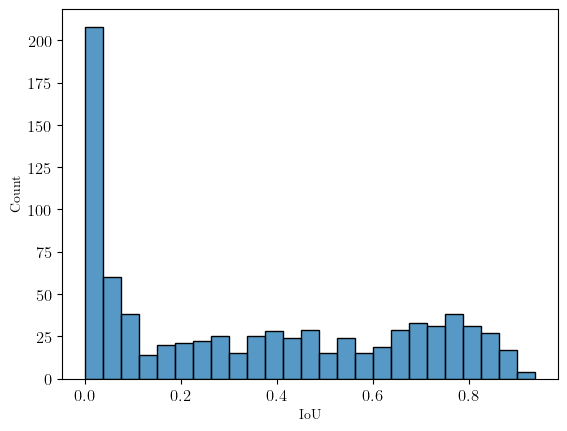

In [96]:
sns.histplot(gdf_overlap.IoU, bins=25)